# Process Analysis

In any manufacture process, we have several stages in a pipeline that converts feedstock into releasable product. It can be all too easy to focus on each of these stages in their material complexity and lose sight of the overall pipeline (i.e. losing sight of the proverbial forest for the trees). Since the goal is to release high quality product as quickly as possible, a key managerial task is to design the process for efficiency. 

To manage such a process and potentially integrate efficiency enhancing resource reallocations or innovations, ideally we'd have some idea of what the impact of those changes would be. A clear view of impact requires us to choose the metrics we seek to optimize. We then need to be able to compare the baseline process to a process that incorporates changes in terms of these metrics. For example, if client release rate is our primary metric of interest, we should be able to understand if the improvement in release rate associated with hiring more people is worth the cost.

In this notebook we will work through an example of software development to fix these ideas. Methodologically, we will use both discrete event simulation and bayesian analysis to analyze a hypothetical process.

In [62]:
import matplotlib.pyplot as plt
import seaborn as sb
import xarray as xr
import pymc as pm
import numpy as np
import graphviz
import arviz as az
import pytensor.tensor as pt
import pytensor
from typing import Optional, Tuple, Set, List, Dict, Union
from statsconcepts.process import ProcessGraph
import simpy as sim
from dataclasses import dataclass


%load_ext autoreload
%aimport statsconcepts.process
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Synopsis of the Analytical Problem

### Motivation

In the competitive software industry, the ability to deliver new features quickly and efficiently is crucial. This requires optimizing the software development process to reduce bottlenecks, minimize cycle times, and maximize the feature release rate. Innovations like parallelizing development stages and automating tasks offer potential improvements, but their impact needs to be carefully evaluated.

### Process Description

The software development process consists of several key stages:

+ Requirements Specification
+ UI/UX Design
+ Backend Development
+ Frontend Development
+ Integration & Testing
+ Deployment & Release

Initially, these stages are executed serially, with each stage depending on the completion of the previous one. However, there is potential to introduce parallelization, such as allowing UI/UX Design and Backend Development to proceed concurrently after the Requirements Specification is complete. The goal is to determine the optimal way to organize and execute these stages.

### Metrics to be Optimized

The primary metrics to be optimized in this analysis are:

**Feature Release Rate (Throughput):** The number of features released per unit of time.
**Pipeline Time (Cycle Time):** The average time it takes for a feature to move from initiation to release.
**Work-in-Progress (WIP):** The number of features in the development pipeline at any given time.

Here is a depiction of the initial process.

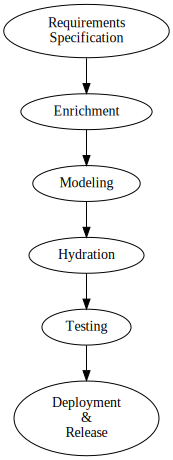

In [39]:
ProcessGraph.serial_data_dev()

Sampling: [concept_dist, process_dist]


array([[<Axes: title={'center': 'process_dist'}>,
        <Axes: title={'center': 'concept_dist'}>]], dtype=object)

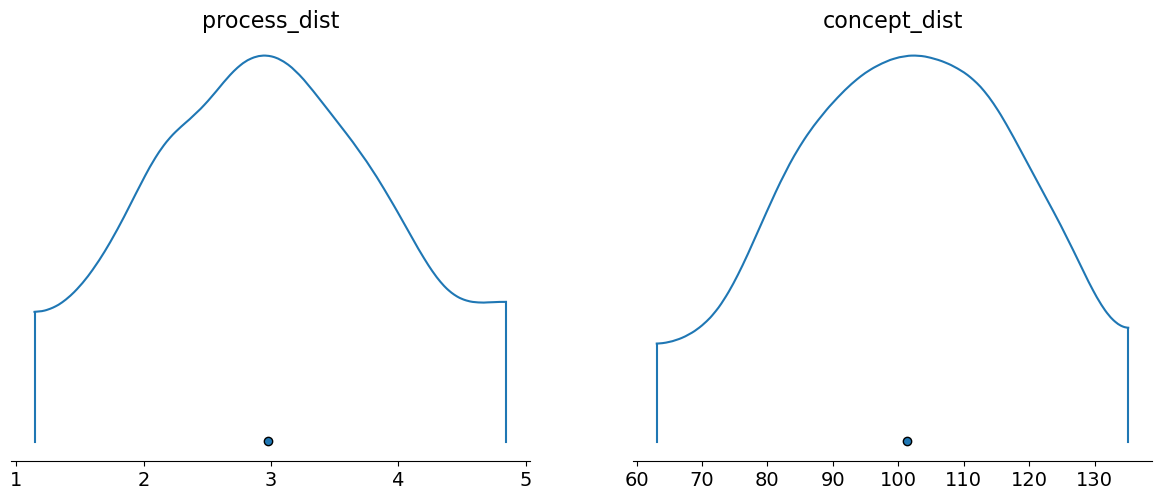

In [73]:
with pm.Model() as process_model:
    # Define priors
    concept_dist: pt.TensorVariable = pm.Normal("concept_dist", mu=100, sigma=20)
    process_dist: pt.TensorVariable = pm.Normal("process_dist", mu=3, sigma=1)
    

# pytensor.dprint(process_model)
process: az.InferenceData = pm.sample_prior_predictive(draws=1000, model=process_model)
az.plot_density(process.prior)

In [74]:
class WidgetContainerGenerator:

    def __init__(self, env: sim.Environment, name: str, concept_dist: np.array, n: int = 10) -> "WidgetContainerGenerator":
        self.env: sim.Environment = env
        self.name: str = name
        self.n: int = n
        self.concept_dist: np.array = concept_dist
        self.widget_containers: List[sim.Container] = self.generate_containers()

    def _generate_container(self) -> sim.Container:
        volume: int = np.random.choice(self.concept_dist, 1)[0]
        return sim.Container(self.env, init=volume, capacity=volume)

    def generate_containers(self) -> List[sim.Container]:
        containers: List[sim.Container] = [self._generate_container() for _ in range(self.n)]
        return containers

class WidgetStore:

    def __init__(self, env: sim.Environment, name: str, capacity: Union[int, float] = np.inf) -> "WidgetStore":
        self.env = env
        self.name = name
        self.store: sim.Store = sim.Store(env, capacity=capacity)

    def source_load(self, generator: WidgetContainerGenerator) -> None:
        for container in generator.widget_containers:
            self.store.put(container)
            print(f"Container {container} added to store {self.name} at time {self.env.now}")

env: sim.Environment = sim.Environment()
wgen: WidgetContainerGenerator = WidgetContainerGenerator(
    env=env, 
    name="wgen", 
    concept_dist=process.prior.concept_dist.values.flatten(),
    n=10
)
source: WidgetStore = WidgetStore(env=env, name="source")
source.source_load(wgen)
sink: WidgetStore = WidgetStore(env=env, name="sink")

Container <simpy.resources.container.Container object at 0x7936e25510d0> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e2551250> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e25515d0> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e2551650> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e25517d0> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e2552450> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e25516d0> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e25519d0> added to store source at time 0
Container <simpy.resources.container.Container object at 0x7936e2550150> added to store source at time 0
Container <simpy.resources.container.Container object a

In [77]:
@dataclass
class Allocation:
    step: int
    label: str
    n_people: int

@dataclass
class Stage:
    step: int
    label: str
    resource: sim.Resource

steps: List[str] = [line.split()[0] for line in ProcessGraph.serial_data_dev().body if "label" in line]
num_people_1: List[int] = [10, 10, 3, 3, 1, 1]
num_people_2: List[int] = [8, 8, 3, 3, 3, 3]
allocations_1: List[Allocation] = [Allocation(step=i, label=steps[i], n_people=num_people_1[i]) for i in range(len(steps))]
allocations_2: List[Allocation] = [Allocation(step=i, label=steps[i], n_people=num_people_2[i]) for i in range(len(steps))]
allocations_1

[Allocation(step=0, label='Requirements', n_people=10),
 Allocation(step=1, label='Enrichment', n_people=10),
 Allocation(step=2, label='Modeling', n_people=3),
 Allocation(step=3, label='Hydration', n_people=3),
 Allocation(step=4, label='Testing', n_people=1),
 Allocation(step=5, label='Deployment', n_people=1)]

In [ ]:
class Pipeline:

    def __init__(
        self, env: sim.Environment, 
        name: str, allocations: List[Allocation], 
        process_dist: np.array,
        pipeline_source: WidgetStore,
        pipeline_sink: WidgetStore
    ) -> "Pipeline":
        self.env = env
        self.name = name
        self.allocations = allocations
        self.process_dist = process_dist
        self.pipeline_source = pipeline_source
        self.pipeline_sink = pipeline_sink
        self.stages = self._gen_stages()

    def _gen_stages(self) -> List[Stage]:
        stages: List[Stage] = []
        for allocation in self.allocations:
            resource: sim.Resource = sim.Resource(self.env, capacity=allocation.n_people)
            stage: Stage = Stage(step=allocation.step, label=allocation.label, resource=resource)
            stages.append(stage)
        return stages

    def run(self) -> None:
        ...

p1: Pipeline = Pipeline(
    env=env,
    name="p1",
    allocations=allocations_1,
    process_dist=process.prior.process_dist.values.flatten(),
    pipeline_source=source,
    pipeline_sink=sink
)
p2: Pipeline = Pipeline(
    env=env,
    name="p2",
    allocations=allocations_2,
    process_dist=process.prior.process_dist.values.flatten(),
    pipeline_source=source,
    pipeline_sink=sink
)

In [70]:
c1 = wstore.store.items[0].get(1)
c1

<ContainerGet() object at 0x7936e26f74d0>

In [ ]:
c1.

1